# Calculator Tool

In [2]:
from sympy import sympify
from langchain.tools import tool
@tool
def calculator(query: str) -> str:
    """This tool evaluates arithmetic expressions using sympy."""
    try:
        return str(sympify(query).evalf())
    except Exception as e:
        return f"Error: {e}"

# Python Code Exector Tool

In [3]:
from langchain.tools import tool
from langchain_experimental.utilities import PythonREPL

python_repl = PythonREPL()

@tool
def Python_Code_Executor(prompt: str) -> str:
    """This tool executes safe Python expressions. Blocks use of dangerous code like import, os, open."""
    blocked_keywords = ["import", "os", "open(", "__", "eval", "exec", "system"]
    
    if any(keyword in prompt for keyword in blocked_keywords):
        return "🙅‍♂️ Disallowed code: unsafe operations detected."
    if not prompt:
        return "No Prompt"
    if not prompt.startswith("print"):
        prompt = f"print({prompt})"
    
    try:
        result = python_repl.run(prompt)
        return result.strip() if result else "No Output"
    except SystemError as e:
        return f"SystemError"
    except Exception as e:
        return f"🙅‍♂️ Error during execution: {e}"


In [4]:
# Python_Code_Executor("len('hello')")

# Web Search Tool

In [5]:
from typing import Optional
from langchain.tools import tool,DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

@tool
def web_search(query:str)->Optional[str]:
    """ This tool is used to search results from web """
    result = search_tool.invoke(query)
    return result

In [6]:
# web_search("Universe")

# RAG

In [6]:
from langgraph.graph import START,END,add_messages,StateGraph
from typing import Sequence,Annotated,TypedDict
from langgraph.prebuilt import ToolNode
from langchain_chroma import Chroma
from langchain_openai import ChatOpenAI,OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader,TextLoader,UnstructuredWordDocumentLoader
from langchain_core.messages import SystemMessage,AIMessage,HumanMessage,BaseMessage
from langchain.tools import tool
from dotenv import load_dotenv
import os

In [6]:
load_dotenv(override=True)

True

In [8]:
def load_docs(folder_path:str):
    all_docs = []
    
    for i,file in enumerate(os.listdir(folder_path)):
        path = os.path.join(folder_path,file)
        
        if file.endswith(".pdf"):
            loader = PyPDFLoader(path)
        elif file.endswith(".txt") or file.endswith(".md"):
            loader = TextLoader(path,encoding="utf-8")
        elif file.endswith(".docx"):
            loader = UnstructuredWordDocumentLoader(path)
        else:
            print(f"Document {i+1}: {path} can't be loaded as it is not in .pdf or .txt or .md")
            continue
        docs = loader.load()
        for d in docs:
            d.metadata['source'] = file
        all_docs.extend(docs)
    return all_docs

In [8]:
os.listdir('../data')

['Agentic_AI.txt', 'MACHINE LEARNING Notes.docx']

In [9]:
docs = load_docs("../data")

In [ ]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
llm = ChatOpenAI(model="gpt-4o-mini")

In [37]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 200
)
split_docs = text_splitter.split_documents(load_docs("../data"))

In [38]:
persist_directory = os.path.join(os.getcwd(),"chroma_db")
os.makedirs(persist_directory,exist_ok=True)
collection_name = "Multi_Agentic_RAG"
try:
    vector_store = Chroma.from_documents(
        documents=split_docs,
        collection_name= collection_name,
        persist_directory=persist_directory,
        embedding=embeddings
    )
except:
    print("ChromaDB not Initialised")
    raise

In [39]:
retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k":5}
)

# Retriever tool

In [7]:
from langchain.tools import tool

@tool
def retriever_tool(query: str) -> str:
    """
    Retrieves relevant chunks from the knowledge base based on user query.
    """
    retrieved_docs = retriever.invoke(query)

    if not retrieved_docs:
        return f"No relevant information found in the knowledge base for query: '{query}'"

    docs = "\n\n".join([
        f"📄 Source: {doc.metadata.get('source', 'unknown')}\n{doc.page_content}"
        for doc in retrieved_docs
    ])
    return docs

# Save Tool

In [8]:
@tool
def save_tool(filename: str, document: str) -> str:
    """Save the document as a .txt file with the given filename."""
    if not document.strip():
        return "Document is empty. Nothing was saved."

    if not filename.endswith('.txt'):
        filename = f"{filename}.txt"

    try:
        with open(filename, 'w', encoding='utf-8') as file:
            file.write(document)
        return f"Document saved successfully as '{filename}'."
    except Exception as e:
        return f"Failed to save document: {str(e)}"


# Summarizer Tool

In [9]:
from langchain.tools import tool
@tool
def summarize_tool(document: str) -> str:
    """Summarize a given piece of text."""
    if not document.strip():
        return "Document is empty. Nothing to summarize."
    return f"Summary: {document[:300]}..." 


In [11]:
tools = [web_search,calculator,Python_Code_Executor,retriever_tool,save_tool]

In [17]:
system_prompt = SystemMessage(content="""
You are a helpful and intelligent assistant with access to a set of powerful tools. 
Use these tools wisely based on the user's query. Always try to provide accurate, useful, and contextual answers.

Here are the tools available to you:

1. `retriever_tool` - Use this to answer questions from a local knowledge base of documents (e.g., notes, manuals).
2. `web_search` - Use this if the user is asking about current events or topics that may change frequently (e.g., "latest news", "current price").
3. `calculator` - Use this for any simple arithmetic or numeric operations (e.g., 22 / 7, 10 * 4.5).
4. `Python_Code_Executor` - Use this for running small Python code snippets or evaluating expressions.
   Do not allow use of unsafe modules like `os`, `open`, or `import`.
5. `save_tool` - Use this only when the user explicitly asks you to save the result to a file.

Guidelines:
- If a tool can help with part of the question, use it.
- Use only the tool relevant to the query — don't mix tools unnecessarily.
- Always explain your reasoning if a tool is not applicable.
- If a user gives follow-up feedback or clarification, treat it as a new message and revise your answer accordingly.
- Be concise but thorough in your responses.
- If multiple tools could help, choose the most appropriate one first.

When using tools, format your input clearly, and focus on solving the user's task efficiently.
""")

In [ ]:

llm_with_tools = llm.bind_tools(tools=tools)

NameError: name 'llm' is not defined

In [2]:
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage],add_messages]
    feedback: bool
    document: str
    retry_count: int
    clarified_query: Optional[str]    

In [12]:
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    feedback: bool
    document: str
    retry_count: int
    clarified_query: Optional[str]

tools = [retriever_tool,calculator,Python_Code_Executor,web_search,save_tool]
tool_node = ToolNode(tools)
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools=tools)

system_prompt = SystemMessage(content="""
You are a helpful and intelligent assistant with access to a set of powerful tools. 
Use these tools wisely based on the user's query. Always try to provide accurate, useful, and contextual answers.

Here are the tools available to you:

1. `retriever_tool` - Use this to answer questions from a local knowledge base of documents (e.g., notes, manuals).
2. `web_search` - Use this if the user is asking about current events or topics that may change frequently (e.g., "latest news", "current price").
3. `calculator` - Use this for any simple arithmetic or numeric operations (e.g., 22 / 7, 10 * 4.5).
4. `Python_Code_Executor` - Use this for running small Python code snippets or evaluating expressions.
   Do not allow use of unsafe modules like `os`, `open`, or `import`.
5. `save_tool` - Use this only when the user explicitly asks you to save the result to a file.

Guidelines:
- If a tool can help with part of the question, use it.
- Use only the tool relevant to the query — don't mix tools unnecessarily.
- Always explain your reasoning if a tool is not applicable.
- If a user gives follow-up feedback or clarification, treat it as a new message and revise your answer accordingly.
- Be concise but thorough in your responses.
- If multiple tools could help, choose the most appropriate one first.

When using tools, format your input clearly, and focus on solving the user's task efficiently.
""")

def should_continue(state: State):
    """Simple routing: check if LLM wants to use tools or if we need feedback"""
    messages = state["messages"]
    last_message = messages[-1]
    
    last_message = state["messages"][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return "tools"
    
    if state.get('feedback', False):
        return "end"
    
    return "feedback"

def human_feedback(state: State) -> State:
    """Get human feedback on the response"""
    agent_response = state['document']
    print(f"\n🧠 Agent Response:\n{agent_response}\n")
    feedback = input("👍 Was this helpful? (y/n): ").strip().lower()
    
    new_state = {**state, "feedback": feedback == 'y'}

    if not new_state["feedback"]:
        new_state["retry_count"] = new_state.get("retry_count", 0) + 1

        if new_state["retry_count"] > 2:
            clarified_query = input("🔍 Please provide a more detailed version of your query:\n> ").strip()
            if clarified_query:
                new_state["clarified_query"] = clarified_query
                new_state["messages"] = [HumanMessage(content=clarified_query)]
    
    return cast(State, new_state) 

def llm_response(state: State) -> State:
    """Generate LLM response"""
    messages = state["messages"]

    # Add system prompt if not present
    if not messages or not isinstance(messages[0], SystemMessage):
        messages = [system_prompt] + list(messages)

    response = llm_with_tools.invoke(messages)

    if isinstance(response, AIMessage) and response.tool_calls:
        print("\n🔧 Tool(s) Selected by Model:")
        for tool_call in response.tool_calls:
            print(f"- Tool name: {tool_call['name']}")
            print(f"  Arguments: {tool_call['args']}\n")
    else:
        print("\n💬 No tool selected. Responding directly.\n")

    return {
        **state,
        "messages": state["messages"] + [response], 
        "document": response.content or "Processing with tools..."
    }




graph_builder = StateGraph(State)

graph_builder.add_node("llm",llm_response)
graph_builder.add_node("tools",tool_node)
graph_builder.add_node("feedback",human_feedback)

graph_builder.add_edge(START,"llm")
graph_builder.add_conditional_edges(
    "llm",
    should_continue,
    {
        "tools":"tools",
        "feedback":"feedback",
        "end":END
    }
    )

graph_builder.add_edge("tools","llm")

graph_builder.add_conditional_edges(
    "feedback",
    lambda state: "end" if state.get('feedback',False) else "llm",
    {
        "llm": "llm",
        "end": END
    }
)
graph = graph_builder.compile()

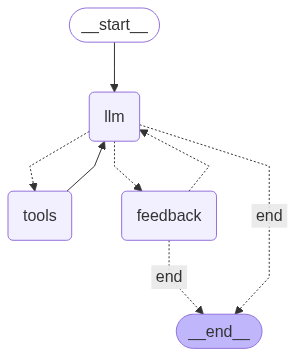

In [13]:
graph

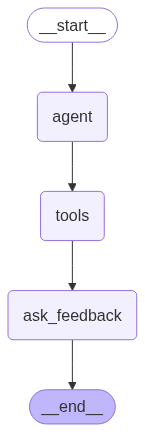

In [ ]:
from langgraph.graph import START,END,add_messages,StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from typing import Sequence,Annotated,TypedDict,Optional,cast
from langchain_chroma import Chroma
from langchain_openai import ChatOpenAI,OpenAIEmbeddings
from langchain_core.messages import SystemMessage,AIMessage,HumanMessage,BaseMessage
from langchain.tools import tool
from dotenv import load_dotenv
import os


# from tools.calculator import calculator
# from tools.python_code_executor import Python_Code_Executor
# from tools.web_search import web_search
# from tools.save import save_tool
# from tools.retriever import retriever_tool
# from tools.summarize import summarize_tool

load_dotenv(override=True)

class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    feedback: bool
    document: str
    retry_count: int
    clarified_query: Optional[str]

tools = [retriever_tool,calculator,Python_Code_Executor,web_search,save_tool,summarize_tool]
tool_node = ToolNode(tools)
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools=tools)



# START -> llm <-> tools <-> feedback
            #  -> feedback -> END

def agent(state:State) -> State:
    system_prompt = SystemMessage(content="""
        You are a helpful and intelligent assistant with access to a set of powerful tools. 
        Use these tools wisely based on the user's query. Always try to provide accurate, useful, and contextual answers.

        Here are the tools available to you:

        1. `retriever_tool` - Use this to answer questions from a local knowledge base of documents (e.g., notes, manuals).
        2. `web_search` - Use this if the user is asking about current events or topics that may change frequently (e.g., "latest news", "current price").
        3. `calculator` - Use this for any simple arithmetic or numeric operations (e.g., 22 / 7, 10 * 4.5).
        4. `Python_Code_Executor` - Use this for running small Python code snippets or evaluating expressions.
        Do not allow use of unsafe modules like `os`, `open`, or `import`.
        5. `save_tool` - Use this only when the user explicitly asks you to save the result to a file.
        6. `summarize_tool` - Use this tool to summaize the response that is generated.

        Guidelines:
        - If a tool can help with part of the question, use it.
        - Use only the tool relevant to the query — don't mix tools unnecessarily.
        - Always explain your reasoning if a tool is not applicable.
        - If a user gives follow-up feedback or clarification, treat it as a new message and revise your answer accordingly.
        - Be concise but thorough in your responses.
        - If multiple tools could help, choose the most appropriate one first.

        When using tools, format your input clearly, and focus on solving the user's task efficiently.
        """)
    messages = state["messages"]
    retry_count = state.get("retry_count", 0)
    feedback = state.get("feedback", True)
    clarified_query = state.get("clarified_query")
    if clarified_query:
        user_message = HumanMessage(content=clarified_query)
        print(f"\n📣 Clarified query: {clarified_query}")
        clarified_query = None
        retry_count = 0
    else:
        if not messages:
            print("\nAI: Hi There how can I assist you: ")
        user_input = input("\nUSER: ")
        if user_input.strip().lower() in ['exit','bye','quit']:
            print("Goodbye")
            exit()
        user_message = HumanMessage(content=user_input)
        print(f"\nUSER: {user_input}")
    all_messages = [system_prompt] +  list(state['messages']) + [user_message]
    response = llm_with_tools.invoke(all_messages)

    print(f"\nAI: {response.content}")
    if hasattr(response,"tool_calls") and response.tool_calls:
        print(f"\nUsing TOOLS: {[t['name'] for t in response.tool_calls]}")
    

    return {
        **state,
        "messages": list(messages) + [user_message, response],
        "feedback": False,
        "retry_count": retry_count,
        "clarified_query": None
    }

def ask_feedback(state: State) -> State:
    messages = state['messages']
    retry_count = state['retry_count']
    user_feedback = input("\n🤖 Was this helpful? (y/n): ").strip().lower()
    
    if user_feedback == "y":
        return {
            **state,
            "feedback": True,
            "retry_count": 0,
            "clarified_query": None
        }

    retry_count += 1
    if retry_count > 2:
        print("\n🔄 Let's try to clarify your question.")
        clarified = input("Please rephrase or clarify your query: ")
        return {
            **state,
            "feedback": False,
            "retry_count": retry_count,
            "clarified_query": clarified
        }

    return {
        **state,
        "feedback": False,
        "retry_count": retry_count,
        "clarified_query": None
    }


def should_continue(state:State):
    """ Simple routing: check if LLM wants to use tools or if we need feedback """
    if state['feedback']:
        return "END"
    return  "continue"

# Build the graph
builder = StateGraph(State)

# Add your nodes
builder.add_node("agent", agent)
builder.add_node("tools", tool_node)
builder.add_node("ask_feedback", ask_feedback)

# Set flow
builder.set_entry_point("agent")
builder.add_edge("agent", "tools")
builder.add_edge("tools", "ask_feedback")
builder.add_conditional_edges("ask_feedback", should_continue)

# Compile and run the graph
graph = builder.compile()
# app = graph.with_config({"recorder": MemorySaver()})
graph

# # Initial state
# state = {
#     "messages": [],
#     "feedback": True,  # doesn't matter on first run
#     "document": "",
#     "retry_count": 0,
#     "clarified_query": None
# }

# app.invoke(state)


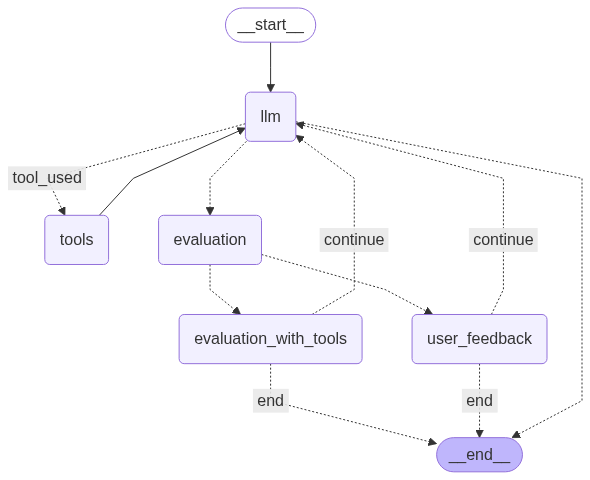

In [12]:
from langgraph.graph import START, END, add_messages, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from typing import Sequence, Annotated, TypedDict, Optional, List, Any
from langchain_chroma import Chroma
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, BaseMessage, ToolMessage
from langchain.tools import tool
from dotenv import load_dotenv
from numpy import lib
from pydantic import BaseModel, Field
import os

# from tools.calculator import calculator
# from tools.python_code_executor import Python_Code_Executor
# from tools.web_search import web_search
# from tools.save import save_tool
# from tools.retriever import retriever_tool
# from tools.summarize import summarize_tool

load_dotenv(override=True)

class State(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]
    feedback: bool
    eval_feedback: bool
    retry_count: int
    clarified_query: Optional[str]
    llm_response: Optional[str]
    evaluator_response: Optional[str]
    tool_use: bool

class Evaluator(BaseModel):
    eval_feedback: bool = Field(description="Whether the response is correct or not")
    reason: str = Field(description="Reason for the feedback")

class Agent:
    def __init__(self):
        self.llm = None
        self.llm_with_tools = None
        self.evaluator = None
        self.evaluate_response = None
        self.tools = None
        self.tool_node = None
        self.graph = None
        self.memory = None
        
    def setup(self):
        # Define tools at class level
        self.tools = [retriever_tool, calculator, Python_Code_Executor, web_search, save_tool, summarize_tool]
        self.tool_node = ToolNode(self.tools)
        
        # Initialize LLMs
        self.llm = ChatOpenAI(model="gpt-4o-mini")
        self.llm_with_tools = self.llm.bind_tools(tools=self.tools)
        self.evaluator = ChatOpenAI(model="gpt-4o-mini").with_structured_output(Evaluator)
        self.evaluator_with_tools = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools=self.tools).with_structured_output(Evaluator)
        
        # Initialize graph and memory
        self.graph = StateGraph(State)
        self.memory = MemorySaver()
    
    def agent(self, state: State) -> State:
        print("🧠 Agent node executed. Proceeding to tool check or evaluation.")
        system_prompt = f"""
            You are a helpful and intelligent assistant equipped with a set of powerful tools. 
            Your goal is to respond accurately, efficiently, and transparently based on the user's query. 
            You are part of a feedback-driven system where your answers may be evaluated and compared, either by a user or by an automated evaluator.

            You have access to the following tools:

            1. `retriever_tool` – Retrieve answers from a local knowledge base of documents (e.g., manuals, reports, notes).
            2. `web_search` – Use this for current or real-time information (e.g., news, weather, stock prices).
            3. `calculator` – Use for arithmetic or numeric calculations (e.g., 22 / 7, 10 * 4.5).
            4. `Python_Code_Executor` – Use this for running simple Python code (e.g., loops, conditionals, expressions).
            ⚠️ Do NOT use or suggest unsafe modules like `os`, `open`, or `import`.
            5. `save_tool` – Use only if the user explicitly asks you to save a response to a file.
            6. `summarize_tool` – Use this to summarize long outputs when needed or upon request.

            ### System Behavior Guidelines:

            - If the query involves real-time data (e.g., current weather, news, events), always prefer using the `web_search` tool instead of relying on prior knowledge.
            - Use tools only when relevant to the query — avoid unnecessary calls.
            - Clearly indicate when a tool was used and summarize its contribution to your answer.
            - You may be evaluated and compared to another evaluator's response. Focus on accuracy and correctness.
            - This is the feedback you got from the evaluator: {state.get('evaluator_response', 'None')}
            - Your response will be stored and may be re-evaluated if the user is not satisfied.
            - If the question is not clear, ask the user to clarify if {state.get('retry_count', 0)} < 3.
            - If a user provides feedback or clarification, treat it as a new message and reprocess accordingly use {state.get('clarified_query', 'None')} as the query.
            - If saving is requested, send a clear and formatted output suitable for file storage.
            - Keep answers concise, but support with factual reasoning or evidence when needed.

            IMPORTANT: When you need to use a tool, you MUST call it. Don't just describe what the tool would do - actually use it!

            Respond intelligently and transparently. Prioritize correctness, efficiency, and user satisfaction.
            """
        
        if self.llm_with_tools is None:
            raise ValueError("Agent not initialized. Please call agent.setup() before using agent().")

        messages = state['messages'].copy()  

        # Add system prompt only if not already present
        if not any(isinstance(m, SystemMessage) for m in messages):
            messages.insert(0, SystemMessage(content=system_prompt))
        
        # Handle clarified query properly
        if state.get("clarified_query") and state.get("retry_count", 0) > 0:
            messages.append(HumanMessage(content=state["clarified_query"]))
        
        response = self.llm_with_tools.invoke(messages)
        
        # Track tool usage
        tool_use = hasattr(response, "tool_calls") and len(response.tool_calls) > 0
        return {
            **state,
            "messages": [response],  
            "llm_response": response.content,
            "tool_use": tool_use,
        }
        
    def llm_router(self, state: State):
        """Route based on whether tools were called"""
        print("➡️ LLM Router is Being Used")
        last_message = state['messages'][-1]
        
        if hasattr(last_message, "tool_calls") and last_message.tool_calls:
            return "tool_used"
        else:
            return "evaluation"
    
    def format_conversation(self, state: State):
        """Format conversation history for evaluator"""
        conversation = "Conversation History:\n\n"
        for message in state['messages']:
            if isinstance(message, HumanMessage):
                conversation += f"User: {message.content}\n"
            elif isinstance(message, AIMessage):
                conversation += f"Assistant: {message.content}\n"
            elif isinstance(message, ToolMessage):
                conversation += f"Tool: {message.content}\n"
        print("🗂️ Formatted Conversation:\n" + conversation)
        return conversation

    
    def evaluate(self, state: State):
        print("🧪 Evaluator without tools running...")
        eval_prompt = SystemMessage(content=f"""
            You are an intelligent evaluator tasked with judging the quality and correctness of an AI assistant's response. 
            You do **not** have access to any tools and must evaluate purely based on the conversation history and the assistant's final response.

            Your job:
            - Verify whether the assistant's answer is factually accurate, logically sound, and aligned with the user's query.
            - Provide a structured judgment.

            Here is the full conversation history:
            {self.format_conversation(state)}

            Final assistant response:
            {state.get('llm_response', '')}

            ## Instructions:
            - Carefully read the assistant's answer.
            - Identify any factual or logical errors.
            - Do **not** attempt to fix or rewrite the answer.
            - Be unbiased in your assessment.

            ## Respond using this structured format:
            - eval_feedback: `True` if the answer is valid, `False` if incorrect.
            - reason: A brief justification for your decision (1-2 lines).
            """)

        evaluator_messages = [eval_prompt] + state["messages"]
        
        # Get structured evaluation
        result: Evaluator = self.evaluator.invoke(evaluator_messages)
        print(f"🧾 Evaluator Result: {result.eval_feedback}, Reason: {result.reason}")

        
        return {
            **state,
            "evaluator_response": result.reason,
            "eval_feedback": result.eval_feedback,
        }
    
    def evaluate_with_tools(self, state: State):
        """Evaluate the assistant's response with tools"""
        print("🧪 Evaluator WITH tools running...")
        
        if self.evaluator_with_tools is None:
            raise ValueError("Agent not initialized. Please call agent.setup() before using agent().")
        
        eval_prompt = SystemMessage(content=f"""
            You are an intelligent evaluator responsible for validating the quality and correctness of an AI assistant's response to a user's query. 
            You have access to tools for verification and may use them as needed.

            Here is the full conversation history:
            {self.format_conversation(state)}

            Final assistant response:
            {state.get('llm_response', '')}

            ## Tools available:
            1. `retriever_tool` – To access internal documents.
            2. `web_search` – For verifying real-time or factual info.
            3. `calculator` – For math or numeric validations.
            4. `Python_Code_Executor` – To test code or logic.
            5. `summarize_tool` – For simplifying long outputs.

            ## Instructions:
            - Review the assistant's reasoning.
            - Use tools **only if needed** to verify accuracy or correctness.
            - Assess whether tools were used properly by the assistant.
            - Be fair and critical, but do not fix or improve responses.

            ## Output:
            - eval_feedback: `True` if the assistant response is factually and logically valid.
            - eval_feedback: `False` if incorrect, incomplete, or misuses tools.
            - reason: Short justification of your evaluation.
            """)

        evaluator_messages = [eval_prompt] + state["messages"]
        result: Evaluator = self.evaluator_with_tools.invoke(evaluator_messages)
        print(f"🧾 Evaluator Result: {result.eval_feedback}, Reason: {result.reason}")

        return {
            **state,
            "evaluator_response": result.reason,
            "eval_feedback": result.eval_feedback,
        }
        
    def user_feedback(self, state: State) -> State:
        """Get user feedback"""
        print(f"\n🤖 Assistant Response: {state.get('llm_response', '')}")
        print(f"✅ Session so far")
        print(f"📊 Retry count: {state.get('retry_count', 0)}")
        print(f"👍 Feedback: {'Positive' if state.get('feedback', False) else 'Negative'}")
        user_feedback = input("AI: Is the llm response correct: say(y/n):")
        feedback = user_feedback.lower() == 'y'
        
        clarified_query = None
        retry_count = state.get('retry_count', 0)
        
        if not feedback and retry_count < 3:
            print("AI: Can you please rephrase your query more clearly?")
            clarified_query = input("User: ")
        
        return {
            **state,
            "feedback": feedback,
            "retry_count": retry_count + 1,
            "clarified_query": clarified_query,
        }
    
    def user_feedback_router(self, state: State):
        if state.get('feedback', False):
            return "end"
        else:
            return "continue"
        
    def evaluator_router(self, state: State):
        # Check if tools were used in the conversation
        tool_use = state.get('tool_use', False)
        print("🔁 Evaluator router decision based on tool use...")
        print(f"➡️ Routing to {'evaluation_with_tools' if state.get('tool_use', False) else 'user_feedback'}")

        if tool_use:
            return "evaluation_with_tools"
        else:
            return "user_feedback"

def create_initial_state():
    """Create initial state with proper defaults"""
    return {
        "messages": [],
        "feedback": False,
        "eval_feedback": False,
        "retry_count": 0,
        "clarified_query": None,
        "llm_response": None,
        "evaluator_response": None,
        "tool_use": False,
    }

# Initialize agent
schema = Agent()
schema.setup()

# Build graph
graph_builder = StateGraph(State)

# Nodes
graph_builder.add_node("llm", schema.agent)
graph_builder.add_node("tools", schema.tool_node)
graph_builder.add_node("evaluation", schema.evaluate)
graph_builder.add_node("evaluation_with_tools", schema.evaluate_with_tools)
graph_builder.add_node("user_feedback", schema.user_feedback)

# Edges
graph_builder.add_edge(START, "llm")

graph_builder.add_conditional_edges(
    "llm",
    schema.llm_router,
    {
        "tool_used": "tools",
        "evaluation": "evaluation"
    }
)

graph_builder.add_edge("tools", "llm")

graph_builder.add_conditional_edges(
    "evaluation",
    schema.evaluator_router,
    {
        "evaluation_with_tools": "evaluation_with_tools",
        "user_feedback": "user_feedback"
    }
)

graph_builder.add_conditional_edges(
    "user_feedback",
    schema.user_feedback_router,
    {
        "end": END,
        "continue": "llm"
    }
)

graph_builder.add_conditional_edges(
    "evaluation_with_tools",
    schema.user_feedback_router,
    {
        "end": END,
        "continue": "llm"
    }
)

# Final compilation
graph = graph_builder.compile(checkpointer=MemorySaver())

graph 

In [ ]:
# Documents -> Load -> Split Chunks -> Embeddings -> Vector Store -> Retriever 

In [1]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [2]:
import os

hf_api_key = os.getenv("HF_API_KEY")
if hf_api_key is not None:
    os.environ["HF_API_KEY"] = hf_api_key

In [3]:
from huggingface_hub import login
login(token=hf_api_key)

d:\MAIN_PROJECTS\Multi_Model_Agentic_RAG\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# from langchain_huggingface import HuggingFaceEndpoint
# import requests
# from langchain.tools import tool

# API_URL = "https://api-inference.huggingface.co/models/runwayml/stable-diffusion-v1-5"
# headers = {"Authorization": f"Bearer {hf_api_key}"}

# @tool
# def generate_image(prompt: str) -> str:
#     """Generate an image from a text prompt using Hugging Face API."""
#     response = requests.post(API_URL, headers=headers, json={"inputs": prompt})
#     image_path = "output.png"
#     with open(image_path, "wb") as f:
#         f.write(response.content)
#     return f"Image saved to {image_path}"

In [5]:
# prompt = "A frog holding a board saying hello"
# generate_image(prompt)

In [6]:
import requests
import json
from PIL import Image
import io
from langchain.tools import tool

@tool
def generate_image(prompt, model_id="black-forest-labs/FLUX.1-dev"):
    """ Use this tool to generate images """
    API_URL = f"https://api-inference.huggingface.co/models/{model_id}"
    headers = {"Authorization": f"Bearer {hf_api_key}"}
    
    payload = {
        "inputs": prompt,
        "parameters": {
            "num_inference_steps": 50,
            "guidance_scale": 7.5
        }
    }
    
    response = requests.post(API_URL, headers=headers, json=payload)
    
    if response.status_code == 200:
        image = Image.open(io.BytesIO(response.content))
        return image
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return None

# Usage
image = generate_image("A Frog jumping over a man")
if image:
    image.save("frog_image.png")

C:\Users\ANAND REDDY\AppData\Local\Temp\ipykernel_21108\1573314702.py:31: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  image = generate_image("A Frog jumping over a man")
